In [1]:
%matplotlib notebook

"""Script to process, calibrate and correct FEE spectra data for LCLS experiment LS49
    Work done by Franklin Fuller (SLAC) and Asmit Bhowmick (LBNL)
    Please specify run number in this cell. For the LS49 work, we used 
    105: Vernier dithering for beam profile correction
    96: Fe-edge data"""

from psana import *
from Detector.EpicsDetector import EpicsDetector
from Detector.AreaDetector import AreaDetector
import numpy as np
from matplotlib.pyplot import *
import xrt.backends.raycing.materials as mat
from scipy.integrate import trapz
import itertools
import math
from scipy.optimize import curve_fit
import h5py
from scipy.interpolate import CubicSpline

ds = DataSource('exp=mfxls4916:run=96:smd')
env = ds.env()

In [2]:
def imshow_robust(i,min_p = 1, max_p = 99):
    """often times events do not have any data in it. This function is to ensure those events are properly handled"""
    vmin, vmax = np.percentile(np.ravel(i),[min_p, max_p])
    figure()
    imshow(i, vmin=vmin, vmax=vmax)

In [3]:
# Now display all epics detnames
epicsNames = DetNames('epics')
print '*** Some Epics Names (Full-Name, DAQ-Alias, User-Alias) ***'
for ename in epicsNames: 
    print ename # only print a few

*** Some Epics Names (Full-Name, DAQ-Alias, User-Alias) ***
('BEAM:LCLS:ELEC:Q', 'EBeam_charge', '')
('BEND:DMP1:400:BDES', 'EBeam_energy', '')
('CXI:R48:EVR:41:TRIG1:BW_TDES', 'picker_evr_delay_calc', '')
('CXI:R48:EVR:41:TRIG1:BW_TWIDCALC', 'picker_evr_width_calc', '')
('CXI:R48:EVR:41:TRIG1:CNT', 'picker_evr_count', '')
('CXI:R48:EVR:41:TRIG1:EC_RBV', 'picker_evr_event_code', '')
('CXI:R48:EVR:41:TRIG1:RATE', 'picker_evr_rate', '')
('CXI:R48:EVR:41:TRIG1:TCTL', 'picker_evr_state', '')
('CXI:R48:EVR:41:TRIG1:TCTL.DESC', 'picker_evr_description', '')
('CXI:R48:EVR:41:TRIG1:TPOL', 'picker_evr_polarity', '')
('CXI:R48:EVR:41:TRIG1:TWID', 'picker_evr_width_set', '')
('ECS:SYS0:7:BEAMPULSEREQ', 'sequencer_beam_request', '')
('ECS:SYS0:7:CURSTP', 'sequencer_current_step', '')
('ECS:SYS0:7:HUTCH_ID', 'sequencer_hutch_id', '')
('ECS:SYS0:7:LEN', 'sequencer_seq_length', '')
('ECS:SYS0:7:PLSTAT', 'sequencer_play_status', '')
('ECS:SYS0:7:PLYCNT', 'sequencer_play_count', '')
('ECS:SYS0:7:PLYCTL

In [4]:
# Storing the epics information here
# We will be needing information regarding emax, emin, ebeam, cam_dist
epics_data = {'bragg': EpicsDetector('FeeSpec_bragg_angle', env),
            'resolution': EpicsDetector('FeeSpec_bragg_angle', env),
            'emax': EpicsDetector('FeeSpec_energy_max', env),
            'emin': EpicsDetector('FeeSpec_energy_min', env),
            'spec': EpicsDetector('FeeSpec_spec', env),
            'ebeam': EpicsDetector('photon_beam_energy', env),
            'cam_dist': EpicsDetector('FeeSpec_camera_distance', env),
            'xtal_angle': EpicsDetector('FeeSpec_crystal_angle', env),
            'cam_angle': EpicsDetector('FeeSpec_camera_angle', env),
              'iris': EpicsDetector('FeeSpec_camera_iris', env),
              'vernier': EpicsDetector('fee_l3vernier', env),
            }
fee_spec = AreaDetector('FEE_Spec', env)
ebeam = Detector('EBeam')

In [5]:
# Hard coding the spectrometer size that is in the stream from shift 2.
# This is not the same as the full spectrometer recording area from the website
img_avg = np.zeros((392, 2050),dtype=np.float32)
count = 0
max_events=4000 # Just putting a cutoff because sometimes towards the end of a run, ebeam does weird things
for nevent,evt in enumerate(ds.events()):
    # includes pedestal subtraction, common-mode correction, bad-pixel
    # suppresion, and returns an "unassembled" 3D array of cspad panels
    calib_array = fee_spec.calib(evt)
    #print ('Calib array shape = ',calib_array.shape)
    if calib_array is not None:
        img_avg += calib_array
        count += 1
        if count > max_events: break

In [6]:
ebeam_data = []
for nevent,evt in enumerate(ds.events()):
    # includes pedestal subtraction, common-mode correction, bad-pixel
    # suppresion, and returns an "unassembled" 3D array of cspad panels
    e = ebeam.get(evt)
    if nevent > 4000: break
    if ebeam is None or e is None: continue
    ebeam_data.append(e.ebeamPhotonEnergy())
print ('LEN OF EBEAM=',len(ebeam_data))

('LEN OF EBEAM=', 0)


<IPython.core.display.Javascript object>


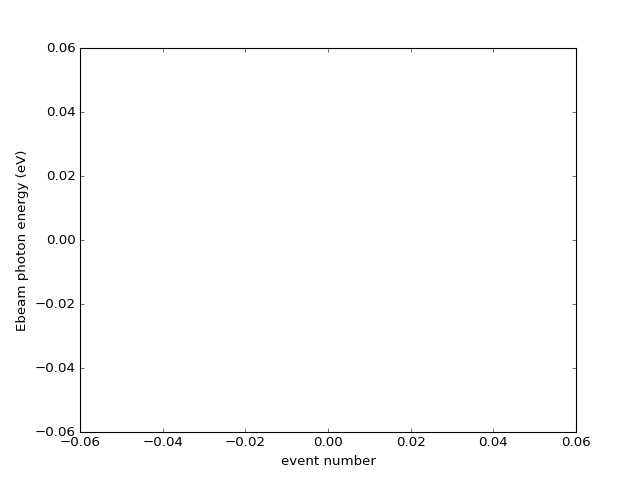

In [7]:
# Plot of ebeam data
# We should use run 105 ebeam data for beam profile correction
# vernier data is junk; epics data is not to be used for shot to shot stuff
figure()
plot(ebeam_data)
xlabel('event number')
ylabel('Ebeam photon energy (eV)')
# plot(vernier)

<IPython.core.display.Javascript object>


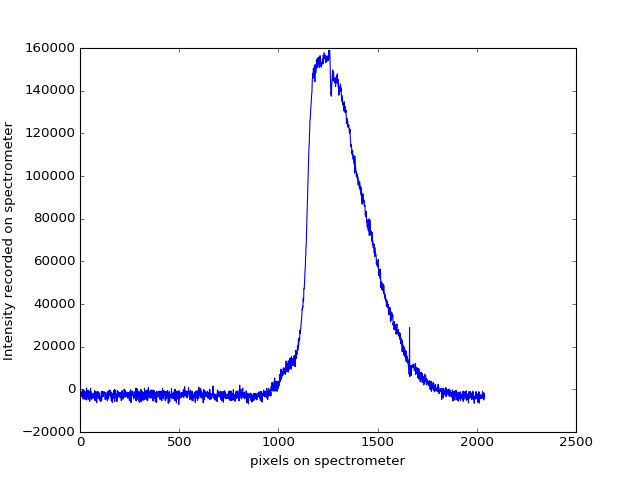

(392, 2040)
7.13323e+06
(array([346]), array([1661]))


In [8]:
# This is the plot of the spectrometer data
# Background subtraction is done here
# Run this for run 96 and see sharp iron edge
figure()
fee_data=img_avg[:,:-10].mean(axis=0) - img_avg[50:100,:-10].mean(axis=0)
#plot(img_avg[:,:-10].mean(axis=0) - img_avg[50:100,:-10].mean(axis=0))
plot(fee_data[:])
#plot([1122]*10, [x*1e5 for x in range(10)],c='r' )
xlabel('pixels on spectrometer')
ylabel('Intensity recorded on spectrometer')
#Visualize the raw data on the spectrometer
#figure()
fee_data=img_avg[:,:-10]-img_avg[25:50,:-10].mean(axis=0)
#imshow(fee_data)
print fee_data.shape
print (np.max(fee_data))
print (np.where(fee_data==np.max(fee_data)))
#colorbar()


In [9]:
# Get pixel position of Fe edge
# Take the mid point as the inflection point
# According to NKS, the curve is inverted and energy increases from right to left (i.e 2050--> 0 pixels)
# Further update --> inflection point is the midpoint of the slower rising curve, not the faster one



Fe_edge_data = img_avg[:,:-10].mean(axis=0) - img_avg[50:100,:-10].mean(axis=0)
Fe_gradient=list(np.gradient(Fe_edge_data))

from scitbx.array_family import flex
Fe_gradient_sorted_idx=flex.sort_permutation(flex.double(Fe_gradient), reverse=True)
# print out the top 5 indexes; the first one is an outlier at 1660
print ('Top 5 indexes of Fe-gradient=', list(Fe_gradient_sorted_idx[:5]))
# !!!!!!!! Take the second one if run 96 !!!!!!!!!!!!!!!!
Fe_edge_pixel_0_idx = Fe_gradient_sorted_idx[1]
print ('Fe edge value intensity and pixel value with 0-indexing=', Fe_edge_data[Fe_edge_pixel_0_idx], Fe_edge_pixel_0_idx)

('Top 5 indexes of Fe-gradient=', [1660, 1141, 1150, 1149, 1142])
('Fe edge value intensity and pixel value with 0-indexing=', 71063.094, 1141)


In [10]:
# Define all helper functions here 
def robust_mean(x):
    return x[np.invert(np.isnan(x))].mean()

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def fwhm(X,Y):
    half_max = Y.max() / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = Y - half_max
    indexes = np.where(d > 0)[0]
    return abs(X[indexes[-1]] - X[indexes[0]])

def robust_mean_asmit(x):
    if len(x)==0: return None
    if np.isnan(x).any(): return None
    return x[np.invert(np.isnan(x))].mean()

def all_gaus(x, all_params):
    y = np.zeros(np.array(x).shape)
    for params in all_params:
        y += gaus(x,*params)
    return y

def find_nearest_idx(nparray, value):
    """courtesy Stack Overflow
    https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array"""
    #array = np.asarray(array)
    idx = (np.abs(nparray - value)).argmin()
    array_value=nparray[idx]
    return array_value,idx

def flag_func(xp, a,comparison='less'):
    """Function compares each element of list x with value a and returns a boolean array
       of 1/0 depending on whether comparison is satisfied"""
    from scitbx.array_family import flex
    if comparison=='less':
        return flex.double([int(xp-a<0.0) for xp in x])
    elif comparison=='greater':
        return flex.double([int(xp-a>0.0) for xp in x])
    else:
        return flex.double([0]*len(xp))

def exgaussian(x, a, mu, sigma, tau):
    import scipy.special as sp
    erfc_input=[(mu+(sigma*sigma/tau)-xp)/(math.sqrt(2)*sigma) for xp in x]
    erfc=sp.erfc(erfc_input)
    #return erfc
    arg_2=[(2*mu+(sigma*sigma/tau)-2*xp)/(2*tau) for xp in x]
    #print ('arg_2',arg_2)
    arg_3=np.exp(arg_2)
    return a*arg_3*erfc/(2*tau)

def plateau_func_1(x,A, mu, sigma):
    """ See https://stats.stackexchange.com/questions/203629/is-there-a-plateau-shaped-distribution"""
    import scipy.special as sp
    erf_input_1=[(xp+mu)/(math.sqrt(2)*sigma) for xp in x]
    erf_input_2=[(xp-mu)/(math.sqrt(2)*sigma) for xp in x]
    erf_1=sp.erf(erf_input_1)
    erf_2=sp.erf(erf_input_2)
    return A*(erf_1-erf_2)/(4*mu)

def plateau_func_2(x, A, mu, sigma, beta):
    """This is the generalized normal subbotin distribution
    beta=2.0 is the normal distribution
    See https://stats.stackexchange.com/questions/203629/is-there-a-plateau-shaped-distribution"""
    from scitbx.math import gamma_complete
    from scitbx.array_family import flex
    xp=flex.double(x)
    return 1.0+A*beta*flex.exp(-(flex.pow(flex.abs(xp-mu)/sigma,beta)))/(2*sigma*gamma_complete(1./beta))

def plateau_func_3(x, A, mu, sigma, w):
    from scitbx.array_family import flex
    xp=flex.double(x)
    h=1./(1+w/(math.sqrt(2*math.pi)*sigma))
    pre_exp=A*h/(math.sqrt(2*math.pi)*sigma)
    term_1=pre_exp*flex.exp(-(xp-mu+w/2)*(xp-mu+w/2)/(2*sigma*sigma))*flag_func(xp,mu-w/2,comparison='less')
    term_2=pre_exp*flag_func(xp,mu-w/2,comparison='less')*flag_func(xp,mu+w/2,comparison='greater')
    term_3=pre_exp*flex.exp(-(xp-mu-w/2)*(xp-mu-w/2)/(2*sigma*sigma))*flag_func(xp,mu+w/2,comparison='greater')
    return term_1+term_2+term_3
    



<IPython.core.display.Javascript object>


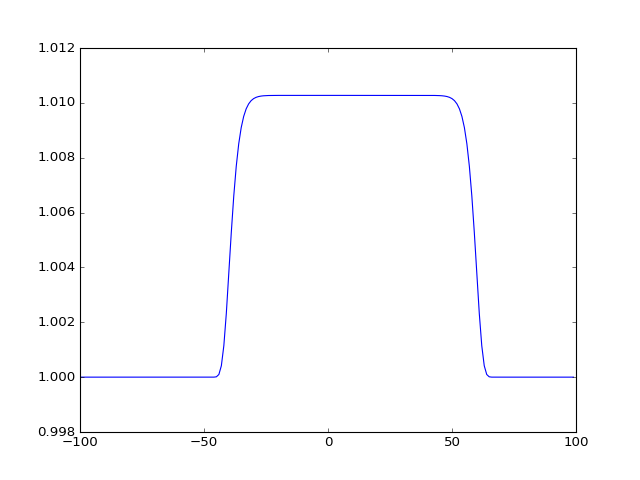

In [11]:
x=range(-100,100,1)
y=plateau_func_2(x,1,10,50,20)
figure()
plot(x,y)

<IPython.core.display.Javascript object>


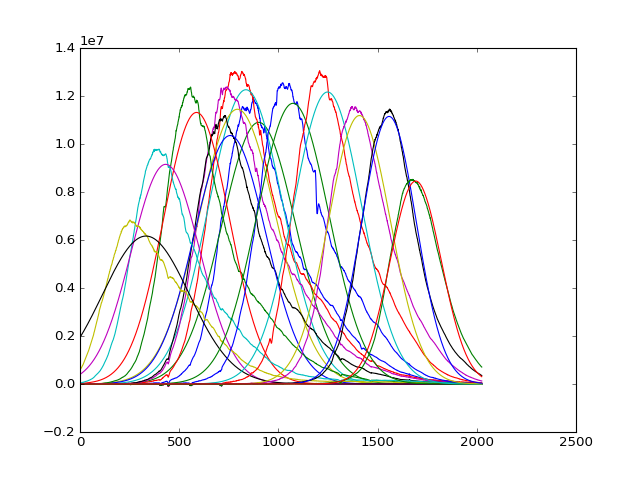

('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', 

('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', 

('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', 

('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', 

In [12]:
# Vignetting correction using xtc stream data directly
#
runs=np.arange(53,65)#[53,54,55,56,57,58,59,61,62,64]#np.arange(53,60)
pscam_xtc=[]
figure()
all_fee_gas = {}
all_img_avg = {}
gauss=True
exgauss=False
for run in runs:
    ds = DataSource('exp=mfxls4916:run=%d:smd'%(run))
    env = ds.env()
    fee_spec = AreaDetector('FEE_Spec', env)
    fee_gas_det = Detector('FEEGasDetEnergy')
    ebeam = Detector('EBeam')
    max_event = 35000
    min_event = 0
    #
    all_fee_gas[run]=[]
    all_img_avg[run]=np.zeros((392, 2036),dtype=np.float32)
    for nevent,evt in enumerate(ds.events()):
        e = ebeam.get(evt)
        calib_array = fee_spec.calib(evt)
        if calib_array is not None:
            try:
            # Determine which bin ev_ebeam falls under
                fee_gas_data=fee_gas_det.get(evt).f_11_ENRC()
                #based on plot of sum(fee_intensity) vs fee_gas_intensity
                # there seems to be real signal only for fee_gas_intensity above 0.2 (linear regime)
                # Otherwise it looks like junk data
                if fee_gas_data < 0.2: continue
                all_fee_gas[run].append(fee_gas_data)
                #print calib_array.shape
                #break
                #tmp_calib=sum(calib_array[:,:-10].mean(axis=0)-calib_array[25:50,:-10].mean(axis=0))
                all_img_avg[run]+=calib_array
            except Exception as e:
                #pass
                print ('Error in calib_array',str(e))

for run in runs:
    img_avg=all_img_avg[run]
    fee_gas=all_fee_gas[run]
        #print (fee_gas)
    fee_gas_correction=robust_mean_asmit(np.array(fee_gas))
    if fee_gas_correction is None: continue
    y0=fee_gas_correction
    y=(img_avg[:,:-10].mean(axis=0) - img_avg[25:50,:-10].mean(axis=0))/fee_gas_correction
    x=range(len(y))
    if gauss:
        popt,pcov = curve_fit(gaus,x,y/y0,p0=[y.max(),x[np.argmax(y)],fwhm(x,y)/2.355])
    if exgauss:
        popt,pcov = curve_fit(exgaussian,x,y/y0,p0=[y.max(),x[np.argmax(y)],fwhm(x,y)/2.355, fwhm(x,y)/2.355])
    #popt,pcov = curve_fit(gaus,x[:-10],y[:-10],p0=[y[:-10].max(),x[:-10][np.argmax(y[:-10])],fwhm(x[:-10],y[:-10])/2.355])
    #popt[0]=max(exgaussian(x,*popt))
    pscam_xtc.append(popt)
        
        #figure()
    plot(x,y/y0)
    if gauss:
        plot(x,gaus(x,*popt))
    #if exgauss:
    #    plot(x,exgaussian(x,*popt), label='run= '+str(run))
    

<IPython.core.display.Javascript object>


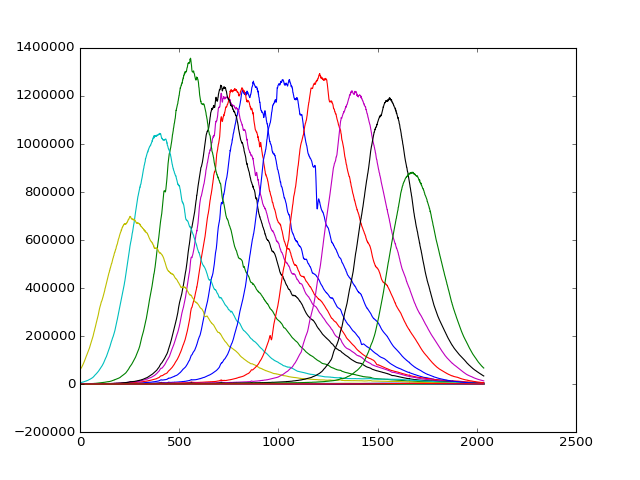

In [46]:
# Vignetting correction using h5 files generated by Franklin
# There was no vignetting correction done in shift 2. Taking the data from runs 53-65 in shift 1 and hoping
# the correction factors are the same
# Exgaussian fits looking better than gaussian

runs = np.arange(53,65) #[53,54,55,56,57,58,59,61,62,64] #np.arange(53,65)
pscam = []
figure()
gauss=False
exgauss=True
for run in runs:
    with h5py.File('/reg/d/psdm/mfx/mfxls4916/hdf5/smalldata/ana-run{:03d}.h5'.format(run)) as fid:
        y = np.array(fid['FEE-SPEC0/hproj']).mean(axis=0)
        y0 = robust_mean(np.array(fid['gas_detector/f_11_ENRC']))
        x = range(len(y))
        #print ('FEE_GAS=',y0,np.array(fid['gas_detector/f_11_ENRC']))
        if gauss:
            popt,pcov = curve_fit(gaus,x,y/y0,p0=[y.max(),x[np.argmax(y)],fwhm(x,y)/2.355])
        if exgauss:
            popt,pcov = curve_fit(exgaussian,x,y/y0,p0=[y.max(),x[np.argmax(y)],fwhm(x,y)/2.355, fwhm(x,y)/2.355])
            
        popt[0]=max(exgaussian(x,*popt))
        pscam.append(popt)
        
        #figure()
        plot(x,y/y0)
        if gauss:
            plot(x,gaus(x,*popt))
        if exgauss:
            plot(x,exgaussian(x,*popt), label='run= '+str(run))
        #legend()

<IPython.core.display.Javascript object>


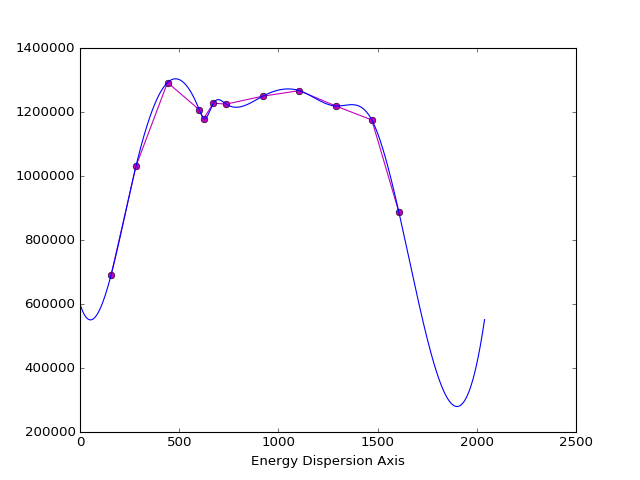

(0.0, 2050.0)
('Final vignetting params=', array([  1.31315338e+06,   9.61281995e+02,   8.30918299e+02]))


In [63]:
# Take the vignetting plot from above and fit a smooth line
# Sweep the camera arm under constant central energy conditions
# Use xtc data
#pscam=pscam_xtc

figure()
axis = np.array([p[1] for p in pscam])
if gauss:
    vals = np.array([p[0] for p in pscam])
if exgauss:
    vals = np.array([p[0] for p in pscam])
    #vals=np.array([np.max(exgaussian(x,*p)) for p in pscam])
s = np.argsort(axis)
plot(axis[s],vals[s],'-o',c='m')
xlabel('Energy Dispersion Axis')
#figure()
x=axis[s]
y=vals[s]
# Add satellite data points for consistency
x=np.insert(x,0,0)
y=np.insert(y,0,600000)
x=np.append(x,2050)
y=np.append(y,600000.0)
cs=CubicSpline(x,y)
vignetting_factor_cs=cs
if True:
    #popt,pcov = curve_fit(gaus,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:-10])/2.355])
    #popt,pcov = curve_fit(plateau_func_2,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355,4.2] )
    #popt,pcov = curve_fit(plateau_func_2,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355,20.0] )
    #popt,pcov = curve_fit(plateau_func_3,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355,10.0] )
    #popt,pcov = curve_fit(exgaussian,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355,fwhm(x[:],y[:])/1.] )
    #plot(x,plateau_func_2(x,*popt),'*-',c='blue')
    popt,pcov = curve_fit(gaus,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355] )
    #plot(x, gaus(x,*popt),'-*')
    #plot(x,plateau_func_2(x,*popt),'*-',c='blue')
    #plot(x,exgaussian(x,*popt),'*-',c='blue')
    print (min(x), max(x))
    xs=np.arange(min(x),max(x)-10,1.0)
    vignetting_factor=list(cs(xs))
    plot(list(xs),vignetting_factor)
    
    #plateau_func_params=popt
vignetting_params=popt
print ('Final vignetting params=',vignetting_params)

In [ ]:
"""Calibration procedure from vernier dithering in run 105. 
Procedure: Get frame by frame energy data from the ebeam value. This should display a sinusoidal/triangular shape
The ebeam value itself in run 105 is off but the range is fine (7040-7120 eV). Taking these energies, we will bin
them in eV bins of 10 eV
"""
# Lets now get the vernier scan stuff from run 105
# CALIBRATION 
#
ds = DataSource('exp=mfxls4916:run=105:smd')
env = ds.env()
ebeam_data = []
fee_data=[]
calib_array_sums=[]
max_event=3000
min_event = 100
max_energy=9140#7115
min_energy=6000#7055
fee_spec = AreaDetector('FEE_Spec', env)
fee_gas_det = Detector('FEEGasDetEnergy')
for nevent,evt in enumerate(ds.events()):
    # includes pedestal subtraction, common-mode correction, bad-pixel
    # suppresion, and returns an "unassembled" 3D array of cspad panels
    e = ebeam.get(evt)
    if nevent > max_event: break
    if nevent < min_event: continue
    if ebeam is None or e is None: continue
    # Filter further based on max and min energies otherwise outliers 
    # will mess things up 
    ev_ebeam = e.ebeamPhotonEnergy()
    if ev_ebeam > max_energy or ev_ebeam < min_energy: continue
    ebeam_data.append(e.ebeamPhotonEnergy())
    #fee_data.append(fee_gas_det.get(evt).f_11_ENRC())
    calib_array = fee_spec.calib(evt)
    if calib_array is not None:
        try:
        #print ('calib_array shape=',calib_array.shape)
        #print ('calib array_sum=',sum(calib_array[:,:-10].mean(axis=0)-calib_array[25:50,:-10].mean(axis=0)))
            fee_data.append(fee_gas_det.get(evt).f_11_ENRC())
            calib_array_sums.append(sum(calib_array[:,:-10].mean(axis=0)-calib_array[25:50,:-10].mean(axis=0)))
        except Exception as e:
            print (str(e))
        
        #break
    #img_avg[:,:-10].mean(axis=0) - img_avg[25:50,:-10].mean(axis=0)
# Plot of ebeam data
# We should use run 105 ebeam data for beam profile correction
# vernier is junk; epics data is not to be used for shot to shot stuff
figure()
plot(ebeam_data)
xlabel('event count(not necessarily event number due to filtering of energies)')
ylabel('Ebeam photon energy (eV)')
# plot(vernier)
figure()
plot(calib_array_sums,fee_data,'*')
xlabel('Sum of FEE spec intensity data i.e total intensity recorded')
ylabel('fee gas intensity data')

In [16]:
print (vignetting_factor)

[600000.0, 586351.77600432944, 572979.95861902449, 559883.70275098784, 547062.16330712242, 534514.4951943307, 522239.85331951553, 510237.39258957945, 498506.26791142533, 487045.63419195585, 475854.64633807371, 464932.4592566815, 454278.22785468207, 443891.10703897802, 433770.25171647209, 423914.81679406704, 414323.9571786655, 404996.82777717017, 395932.58349648386, 387130.3792435092, 378589.36992514884, 370308.71044830559, 362287.55571988208, 354525.06064678106, 347020.38013590529, 339772.66909415729, 332781.08242843993, 326044.77504565578, 319562.90185270773, 313334.61775649828, 307359.07766393031, 301635.43648190639, 296162.84911732934, 290940.4704771018, 285967.45546812646, 281242.95899730612, 276766.13597154338, 272536.14129774086, 268552.1298828015, 264813.25663362781, 261318.67645712267, 258067.5442601887, 255059.01494972856, 252292.24343264499, 249766.38461584056, 247480.59340621825, 245434.02471068062, 243625.83343613037, 242055.17448947023, 240721.20277760277, 239623.073207430

('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")
('Error in calib_array', "'NoneType' object has no attribute 'f_11_ENRC'")


<IPython.core.display.Javascript object>


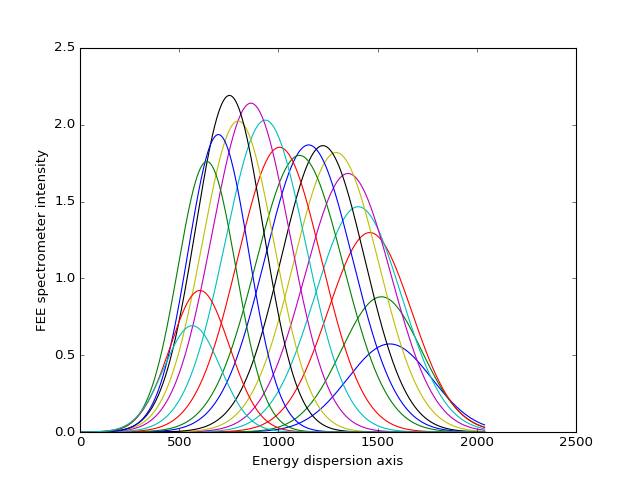

('3 sigma boundaries ', 2055.2974358138717, 749.13531240096768)
('3 sigma boundaries ', 992.28174688423223, 139.57227397140355)


In [100]:
# Define some helper functions here
# Try to be smart about running the binning calculations
#

def flag_func2(x,lower, upper):
    """Returns a boolean of 1 between upper and lower limit. 0 outside limit"""
    n=len(x)
    y=[]
    for entry in range(n):
        if entry > lower and entry < upper:
            y.append(1.0)
        else:
            y.append(0.0)
    return y

def clamp_function(x, lower, upper):
    """Clamps a function to be 0 outside upper and lower limit"""
    y=[]
    n=len(x)
    for entry in range(n):
        if entry > lower and entry < upper:
            y.append(1.0/x[entry])
        else:
            y.append(0.0)
    return y
            
    
ds = DataSource('exp=mfxls4916:run=105:smd')
env = ds.env()
fee_spec = AreaDetector('FEE_Spec', env)
fee_gas_det = Detector('FEEGasDetEnergy')
ebeam = Detector('EBeam')
count=0
max_energy=7115.0#7115.0 
min_energy=7043.0#7055.0
num_bins=18
max_event = 35000
min_event = 0
# Set up the arrays for binning
delta_E=(max_energy-min_energy)/num_bins
all_img_avg={}
all_fee_gas={}
central_energies=[]
stored_central_energies=[]
# Setup arrays in the dictionaries 
for i_bin in range(1,num_bins+1):
    central_energy=min_energy+(i_bin-0.5)*delta_E
    all_img_avg[central_energy]=np.zeros((392, 2050),dtype=np.float32)
    all_fee_gas[central_energy]=[]
    central_energies.append(central_energy)
# Now l
for nevent,evt in enumerate(ds.events()):
    e = ebeam.get(evt)
    if nevent > max_event: break
    if nevent < min_event: continue
    if ebeam is None or e is None: continue
    # Filter further based on max and min energies otherwise outliers 
    # will mess things up 
    ev_ebeam = e.ebeamPhotonEnergy()
    if ev_ebeam > max_energy or ev_ebeam < min_energy: continue
    calib_array = fee_spec.calib(evt)
    if calib_array is not None:
        try:
            # Determine which bin ev_ebeam falls under
            fee_gas_data=fee_gas_det.get(evt).f_11_ENRC()
            #based on plot of sum(fee_intensity) vs fee_gas_intensity
            # there seems to be real signal only for fee_gas_intensity above 0.2 (linear regime)
            # Otherwise it looks like junk data
            if fee_gas_data < 0.2: continue
            central_energy,idx=find_nearest_idx(np.array(central_energies),ev_ebeam)
            all_fee_gas[central_energy].append(fee_gas_data)
            all_img_avg[central_energy]+=calib_array
            
        except Exception as e:
            print ('Error in calib_array',str(e))

##########################################################################################################
##   Plot the intensity reading on the FEE spectrometer vs pixel space for each of the eV bins         ##
##   Also fit gaussians to each of the eV curves. Finally fit a gaussian to the sum of the 6 gaussians ##
#########################################################################################################        
if True:
    psprof=[]
    all_fee_I_max=[]
    all_fee_I_px=[]
    figure()
    #
    # This is only for identifying the extremes of the distribution
    if False:
        #central_energies=[7112.5, 7057.5]
        central_energies=[7113.0, 7057.0]
        
    apply_vignetting_corrections=True
    #if apply_vignetting_corrections:
    #    vignetting_factor=clamp_function(vignetting_factor, 300,1800)
        
    for i_energy, central_energy in enumerate(central_energies):
        img_avg=all_img_avg[central_energy]
        fee_gas=all_fee_gas[central_energy]
        #print (fee_gas)
        fee_gas_correction=robust_mean_asmit(np.array(fee_gas))
        if fee_gas_correction is None: continue
        y=(img_avg[:,:-10].mean(axis=0) - img_avg[25:50,:-10].mean(axis=0))/fee_gas_correction
        x=range(len(y))
        
        
        if apply_vignetting_corrections:
            #vignetting_factor=cs()
            #vignetting_factor=plateau_func_2(x,*vignetting_params)
            #vignetting_factor=gaus(x,*vignetting_params)
            #vignetting_factor=clamp_function(vignetting_factor, 300,1800)
            y=y/vignetting_factor
            
            
        #if np.max(y) < 1.0 or np.max(fee_gas) < 0.2: continue # arbitrary but will work for now
        #print (np.max(y), np.min(y), y.shape, i_energy)
        popt,pcov = curve_fit(gaus,x[:-10],y[:-10],p0=[y[:-10].max(),x[:-10][np.argmax(y[:-10])],fwhm(x[:-10],y[:-10])/2.355])
        psprof.append(popt)
        all_fee_I_max.append(np.max(y))
        all_fee_I_px.append(x[np.argmax(y)])
        #stored_central_energies.append(central_energy)
        #plot(x[300:1800],y[300:1800])
        ##### plot(x,y)
        xlabel('Energy dispersion axis')
        ylabel('FEE spectrometer intensity')
        plot(x,gaus(x,*popt))
        #if central_energy in [7112.5,7057.5]:
        if central_energy in [7113.0, 7057.0]:
            #print ('Print 2sigma of gaussians=',gaus([popt[1]+2*popt[2]],*popt), gaus([popt[1]-2*popt[2]],*popt))
            print ('3 sigma boundaries ',popt[1]+3*popt[2],popt[1]-3*popt[2])
    
    
    # Gaussian fit to the sum of all 6 gaussians. Will help us obtain the 60 eV window on the spectrometer
    # Visually inspect this plot to get the reading for 60 eV window 
    if False:
        z = all_gaus(x,psprof)
        print np.where(z==max(z))
        plot(x, z, color='orange',label='sum of each of the gaussians at each point')

else:
    figure()
    fee_gas_mean=robust_mean_asmit(np.array(all_fee_gas[central_energies[0]]))
    
    imshow(all_img_avg[central_energies[0]][:,:-10]/fee_gas_mean)



In [102]:
#figure()
#plot(all_fee_I_px,all_fee_I_max,'o')
print (central_energies)
print (psprof)
print (central_energies[0]-central_energies[1])/(psprof[0][1]-psprof[1][1])



[7045.0, 7049.0, 7053.0, 7057.0, 7061.0, 7065.0, 7069.0, 7073.0, 7077.0, 7081.0, 7085.0, 7089.0, 7093.0, 7097.0, 7101.0, 7105.0, 7109.0, 7113.0]
[array([  5.73305884e-01,   1.56139522e+03,   2.12667648e+02]), array([  8.80312490e-01,   1.51900677e+03,   2.01452334e+02]), array([  1.29836749e+00,   1.46063826e+03,   2.10691710e+02]), array([    1.46675461,  1402.21637411,   217.69368724]), array([    1.68308397,  1351.04729531,   217.22215412]), array([    1.81961914,  1290.79009148,   213.86073313]), array([    1.86422087,  1224.14664524,   210.3829377 ]), array([    1.86897042,  1152.51207815,   220.11210523]), array([    1.80098063,  1105.7803632 ,   220.54799112]), array([    1.85379836,  1005.25174752,   211.48603437]), array([   2.03052463,  933.64250763,  202.79135651]), array([   2.14078426,  861.31055778,  194.6815916 ]), array([   2.02510763,  797.29381461,  181.24086744]), array([   2.19122545,  753.17937324,  170.24877374]), array([   1.9364078 ,  697.55130605,  152.7584652 

<IPython.core.display.Javascript object>


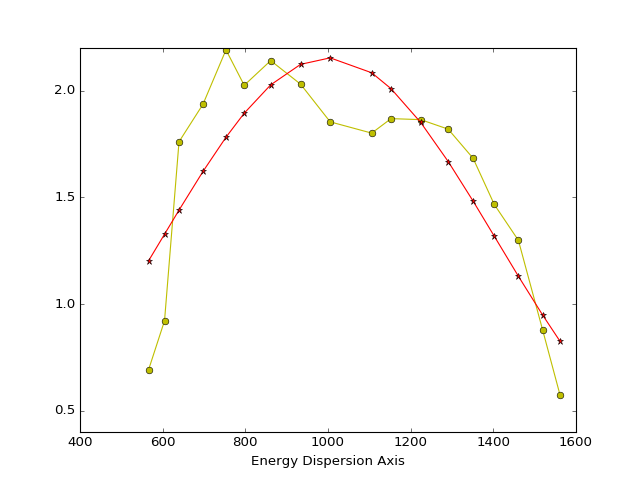

('lenghts=', 18, 18)
(0.57330588391055815, 1561.3952214682379)


In [101]:
# Beam profile correction factor calculation. 
# Take the max of each of the gaussians and fit a gaussian. 
# Divide the intensities by this factor at each eV value
#


figure()
axis = np.array([p[1] for p in psprof])
vals = np.array([p[0] for p in psprof])
#print ('axis=0 VALUES',vals)
s = np.argsort(axis)
plot(axis[s],vals[s],'o-',label='Max of each eV curve fit',c='y')
x=axis[s]
y=vals[s]#/gaus(x,*vignetting_params)
if False:
    x=np.array(all_fee_I_px)
    y=np.array(all_fee_I_max)
#print ('WHATSY=',y)
print ('lenghts=',len(x),len(y))
test_x=range(-10,10)
#exgauss=exgaussian(test_x,1,0,1,1) # see wikipedia for correct curve
#print ('EXGAUSS=',exgauss)
gauss=True
exgauss=False
is_plateau_func=False
is_cubic_spline=True
print (min(y), x[np.argmin(y)])
#figure()
if gauss:
    popt,pcov = curve_fit(gaus,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355])
    plot(x,gaus(x,*popt),'*-',c='red')
    gauss_params=popt
if exgauss:
    popt,pcov = curve_fit(exgaussian,x,y,p0=[y.max(), x[np.argmax(y)], fwhm(x[:],y[:])/2.355, fwhm(x[:],y[:])/2.355])
    #print (popt)
    plot(x,exgaussian(x,*popt),'*-',c='green')
    exgauss_params=popt

if is_plateau_func:
    #popt,pcov = curve_fit(plateau_func_1,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355])
    popt,pcov = curve_fit(plateau_func_2,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355,5.0] )
    #popt,pcov = curve_fit(plateau_func_3,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355,10.0] )
    plot(x,plateau_func_2(x,*popt),'*-',c='blue')
    #plot(x,plateau_func_3(x,*popt),'*-',c='blue')
    plateau_func_params=popt

if is_cubic_spline:
    
    # Add satellite data points for consistency
    y_min=2*min(y)
    x=np.insert(x,0,0)
    y=np.insert(y,0,0.5*y_min)
    x=np.insert(x,1,100)
    y=np.insert(y,1,0.55*y_min)
    #
    x=np.append(x,1648)
    y=np.append(y,0.54*y_min)
    x=np.append(x,1748)
    y=np.append(y,0.53*y_min)
    x=np.append(x,1848)
    y=np.append(y,0.52*y_min)
    x=np.append(x,1948)
    y=np.append(y,0.51*y_min)    
    x=np.append(x,2048)
    y=np.append(y,0.5*y_min)
    beam_profile_cs=CubicSpline(x,y)
    #plot(x,beam_profile_cs(x),'*-',c='blue')
    
    

#legend()
#
# !!! Beam profile correction params saved here !!!
beam_profile_corr_params = popt
#print popt
xlabel('Energy Dispersion Axis')
if False:
    figure()
    x=range(2048)
    #y=exgaussian(x,*exgauss_params)
    #y=plateau_func_2(x,*plateau_func_params)
    #plot(x,y,c='g')
    y=gaus(x,*gauss_params)
    print ('GAUSSIAN PARAMS=',gauss_params)
    #plot(x,y,c='r')
    xs=np.arange(min(x),max(x)-10,1.0)
    ys=beam_profile_cs(xs)
    plot(xs[500:1500],ys[500:1500],c='b')
    #plot(test_x,exgauss)

<IPython.core.display.Javascript object>


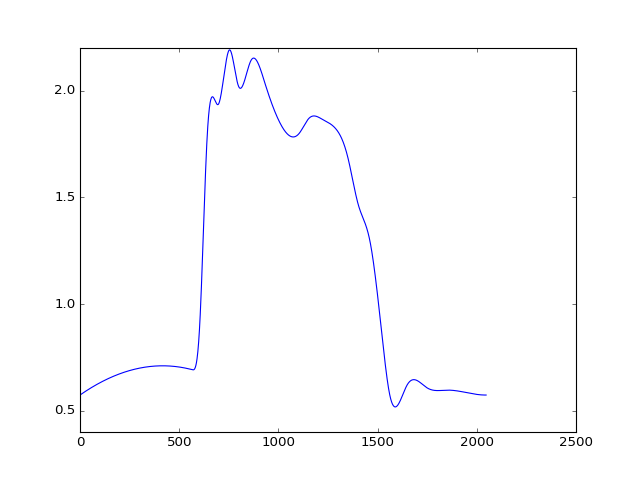

In [77]:
# Constructing beam profile correction
#x_beam_profile=np.arange(0,2048,1.0)
xs=np.arange(0,2048, 1.0)
ys=beam_profile_cs(xs)

#y_beam_profile=cs(x_beam_profile)
figure()
plot(xs[:],ys[:])

In [ ]:
# Try to see if the gaussians we are using for each bin are truly gaussians
# Plot the raw data for each bin separately or maybe just the extremes
if True:
    #figure()
    central_energies_tmp=central_energies
    #
    # This is only for identifying the extremes of the distribution
    if False:
        central_energies_tmp=[7112.5, 7057.5]
        print (central_energies)
        central_energies_tmp=[7126.5, 7027.5]
    for i_energy, central_energy in enumerate(central_energies_tmp):
        img_avg=all_img_avg[central_energy]
        fee_gas=all_fee_gas[central_energy]
        fee_gas_correction=robust_mean_asmit(np.array(fee_gas))
        if fee_gas_correction is None: continue
        y=(img_avg[:,:-10].mean(axis=0) - img_avg[25:50,:-10].mean(axis=0))/fee_gas_correction
        x=range(len(y))
        if np.max(y) < 1.0 or np.max(fee_gas) < 0.2: continue # arbitrary but will work for now
        print (np.max(y), np.min(y), y.shape, i_energy)
        figure()
        plot(x,y, label=str(central_energy)+' eV')
        tmp_params=psprof[stored_central_energies.index(central_energy)]
        y=gaus(x,*tmp_params)
        plot(x,y,c='r')
        legend()

In [ ]:
# Lets fit the data to gaussians; also need to do the fee gas detector normalization

import h5py

runs = [105]#np.arange(46,53)
psprof = []
figure()
for run in runs:
    with h5py.File('/reg/d/psdm/mfx/mfxls4916/hdf5/smalldata/ana-run{:03d}.h5'.format(run)) as fid:
        y = np.array(fid['FEE-SPEC0/hproj']).mean(axis=0)
        y0 = robust_mean(np.array(fid['gas_detector/f_11_ENRC']))
        x = range(len(y))
        print (len(y), len(y0))
        #popt,pcov = curve_fit(gaus,x[:-10],y[:-10]/y0,p0=[y[:-10].max(),x[:-10][np.argmax(y[:-10])],fwhm(x[:-10],y[:-10])/2.355])
        #psprof.append(popt)
        #plot(x[:-10],y[:-10]/y0)
        #plot(x,gaus(x,*popt))
        #plot(y,y0)


-0.0336322869955 7149.80269058
1141 7111.42825112
826.666666667 7122
1718.66666667 7092
-65.3333333333 7152
[826, 1718, 100]


<IPython.core.display.Javascript object>


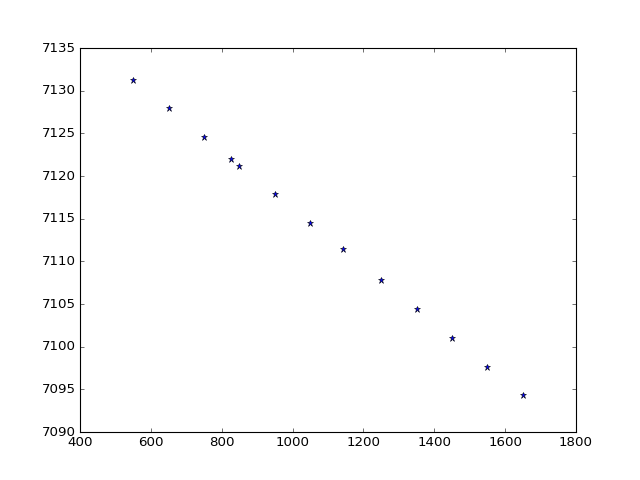

In [111]:
# Calibration
# Fe-edge position is known (x0,y0)=(1124,7112) (1141 from shift 2; 1124 from shift 3)
# Use delta_y = y2-y1 = 7115-7055 = 60eV
# Use delta_x = x2-x1= 139-1923 # Reading it off the gaussian fit (all_gaus; look at the extremes)
# Now fit a straight line using the equation
# (y-y0)/(x-x0)=(y2-y1)/(x2-x1)
#
x0=1124 # Accounting for 10 pixels ignored 
y0=7112 # Fe-edge 
slope=60.0/(139-1923) # Ignore 10 pixels because they cancel out

# defining slope using vignetting corrected beam profile data: use nbins=18
# 1. using the mean of 7113 and 7057 instead of 3sigma
#slope=(7113-7057)/(566.-1402.)
# 2. use the 3 sigma values of 139 and 2055
#slope=(72)/(139.0-2055.0)

##slope=60.0/(97-1963)
intercept=y0-slope*x0
print slope, intercept
# Try Fe-edge value for consistency check
x=1141
y=slope*x+intercept
print x,y
boundary_pixels = []
# Find pixel for 7122 eV
y=7122
x=(y-intercept)/slope
print x,y
boundary_pixels.append(int(x))
# Find bounding pixels for 7122-30 & 7122+30 eV
y=7092
x=(y-intercept)/slope
print x,y
if x > 2000: x=2000
boundary_pixels.append(int(x))
y=7152
x=(y-intercept)/slope
print x,y
if x <100: x=100
boundary_pixels.append(int(x))
print (boundary_pixels)

x=[550,650,750,826,850,950,1050,1141,1250,1350,1450,1550,1650]
y=[xx*slope+intercept for xx in x]
figure()
plot(x,y,'*')

In [ ]:
# Try to get the beam profile correction by getting profile from
# the horizontal direction
# Try to be smart about running the binning calculations
#

ds = DataSource('exp=mfxls4916:run=105:smd')
env = ds.env()
fee_spec = AreaDetector('FEE_Spec', env)
fee_gas_det = Detector('FEEGasDetEnergy')
count=0
max_energy=7140.0 #7115.0 
min_energy=7000.0 #7055.0
num_bins=140
max_event = 35000
min_event = 0
# Set up the arrays for binning
delta_E=(max_energy-min_energy)/num_bins
all_img_avg={}
all_fee_gas={}
central_energies=[]
# Setup arrays in the dictionaries 
for i_bin in range(1,num_bins+1):
    central_energy=min_energy+(i_bin-0.5)*delta_E
    all_img_avg[central_energy]=np.zeros((392, 2050),dtype=np.float32)
    all_fee_gas[central_energy]=[]
    central_energies.append(central_energy)
# Now l
for nevent,evt in enumerate(ds.events()):
    e = ebeam.get(evt)
    if nevent > max_event: break
    if nevent < min_event: continue
    if ebeam is None or e is None: continue
    # Filter further based on max and min energies otherwise outliers 
    # will mess things up 
    ev_ebeam = e.ebeamPhotonEnergy()
    if ev_ebeam > max_energy or ev_ebeam < min_energy: continue
    calib_array = fee_spec.calib(evt)
    if calib_array is not None:
        try:
            # Determine which bin ev_ebeam falls under
            central_energy,idx=find_nearest_idx(np.array(central_energies),ev_ebeam)
            all_img_avg[central_energy]+=calib_array
            all_fee_gas[central_energy].append(fee_gas_det.get(evt).f_11_ENRC())
        except Exception as e:
            print ('Error in calib_array',str(e))

##########################################################################################################
##   Plot the intensity reading on the FEE spectrometer vs pixel space for each of the eV bins         ##
##   Also fit gaussians to each of the eV curves. Finally fit a gaussian to the sum of the 6 gaussians ##
#########################################################################################################        
if True:
    psprof=[]
    figure()
    #
    # This is only for identifying the extremes of the distribution
    if False:
        all_img_avgs=[img_avg_7112_5, img_avg_7057_5]
        all_fee_gas=[fee_gas_7112_5, fee_gas_7057_5]
    for i_energy, central_energy in enumerate(central_energies):
        img_avg=all_img_avg[central_energy]
        fee_gas=all_fee_gas[central_energy]
#####

        y=(img_avg[:,:-10].mean(axis=1) - img_avg[:,25:50].mean(axis=1))/robust_mean_asmit(np.array(fee_gas))
        print (np.max(y), np.min(y), y.shape)
        v=np.argmax(img_avg[:,:-10].max(axis=0) - img_avg[25:50,:-10].mean(axis=0))
        x=range(len(y))
        if np.max(y) < 1.0: continue # arbitrary but will work for now
        popt,pcov = curve_fit(gaus,x[:-10],y[:-10],p0=[y[:-10].max(),x[:-10][np.argmax(y[:-10])],fwhm(x[:-10],y[:-10])/2.355])  
        #counter+=1
        disp_axis=range(2038)
        # Manipulate the gaussian to represent the dispersion axis
        popt[1]=v*1.0
        psprof.append(popt)
        print (popt)
        #print ('3 sigma boundaries ',popt[1]+3*popt[2],popt[1]-3*popt[2])

        #color_array=[0,0,float(counter)/len(all_fee_gas)]
        #plot(y)
        #plot(x,gaus(x,*popt))
        #plot(x,quadratic(x,*popt))
        plot(disp_axis, gaus(disp_axis, *popt))
        #plot(disp_axis, quadratic(disp_axis, *popt))
#####
    
    
    
    
    # Gaussian fit to the sum of all 6 gaussians. Will help us obtain the 60 eV window on the spectrometer
    # Visually inspect this plot to get the reading for 60 eV window 
    if False:
        z = all_gaus(x,psprof)
        print np.where(z==max(z))
        plot(x, z, color='orange',label='sum of each of the gaussians at each point')

else:
    figure()
    fee_gas_mean=robust_mean_asmit(np.array(all_fee_gas[central_energies[0]]))
    
    imshow(all_img_avg[central_energies[0]][:,:-10]/fee_gas_mean)

In [ ]:
#
# Beam profile correction factor calculation. 
# Take the max of each of the gaussians and fit a gaussian. 
# Divide the intensities by this factor at each eV value
#
figure()
axis = np.array([p[1] for p in psprof])
vals = np.array([p[0] for p in pThis sprof])
#print ('axis=1 VALUES=',vals)
s = np.argsort(axis)
plot(axis[s],vals[s],'o-')
x=axis[s]
y=vals[s]
popt,pcov = curve_fit(gaus,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355])
#popt,pcov = curve_fit(quadratic,x[:],y[:],p0=[y[:].max(),x[:][np.argmax(y[:])],fwhm(x[:],y[:])/2.355])
plot(x,gaus(x,*popt),'*-')
#plot(x,quadratic(x,*popt),'*-')
#plot(range(2038),gaus(range(2038), *popt))
#plot(range(2048),quadratic(range(2048), *popt))
legend()
#
# !!! Beam profile correction params saved here !!!
beam_profile_corr_params = popt
xlabel('Energy Dispersion Axis')
print (popt)

<IPython.core.display.Javascript object>


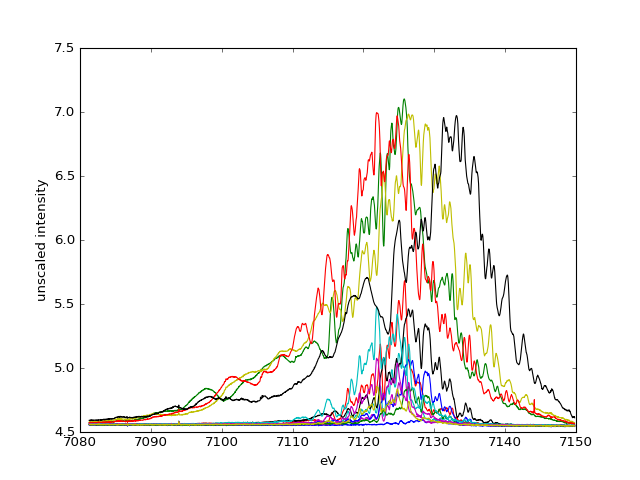

<IPython.core.display.Javascript object>


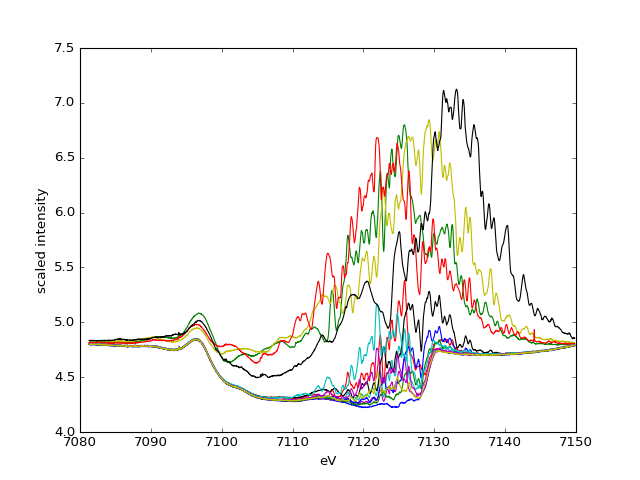

In [132]:
# Playing around with spectra for some real data.
# This should only be taken seriously once the calibration and corrections have been done

def get_center_of_ev_spec(fee_spec):
    numer=0.0
    denom=0.0
    ev_axis=[x*slope+intercept for x in range(2038)]
    for ii, fee_data in enumerate(fee_spec):
        numer += float(ev_axis[ii])*fee_data
        denom += fee_data
    return numer/denom

ds = DataSource('exp=mfxls4916:run=223:smd')
env = ds.env()
fee_spec = AreaDetector('FEE_Spec', env)
fig1=figure()
fig2=figure()
ax1=fig1.gca()
ax2=fig2.gca()
#ax2=figure()
ev_axis=[x*slope+intercept for x in range(2038)]
#print max(ev_axis)
#print scaled_data.shape
for nevent,evt in enumerate(ds.events()):
    if nevent < 5: continue
    calib_array = fee_spec.calib(evt)
    e=ebeam.get(evt) 
    #if e is not None:
        #print ('EBEAM photon energy = ',e.ebeamPhotonEnergy())
    if calib_array is not None:
        data=calib_array[:,:-10].sum(axis=0) - calib_array[25:50, :-10].sum(axis=0)
        #scale_factor = gaus(range(2038),*beam_profile_corr_params)
        xs=range(2038)
        scale_factor=beam_profile_cs(xs)#*vignetting_factor_cs(xs)
        #scale_factor = exgaussian(range(2038),*beam_profile_corr_params)
        #scale_factor = plateau_func_2(range(2038),*beam_profile_corr_params)
        #plot(scale_factor)
        #scale_factor = quadratic(range(2038),*beam_profile_corr_params)
        #plot(data)
        if True:
            #ax1.plot(ev_axis,data-min(data))
            ax1.plot(ev_axis,np.log10(1+data))
            #ylim((0,10.0))
        #print ('Minimum FEE data=',min(data), np.where(data==min(data)))
        if True:
            #scaled_data=(data-min(data))/(scale_factor)
            scaled_data=data/scale_factor
            #ax2.plot(ev_axis, scaled_data)
            ax2.plot(ev_axis, np.log10(1.0+scaled_data))
        if e is not None:
            print ('EBEAM photon energy=',e.ebeamPhotonEnergy(), get_center_of_ev_spec(scaled_data))
        #xlim((500,1500))
        #print max(scaled_data)
        #ax1.plot([ev_axis[boundary_pixels[0]]]*2,[0,max(data)],'-',linewidth=5, color='yellow', alpha=0.3)
        #ax1.plot([ev_axis[boundary_pixels[1]]]*2,[0,max(data)],'-',linewidth=5, color='grey', alpha=0.1)
        #ax1.plot([ev_axis[boundary_pixels[2]]]*2,[0,max(data)],'-',linewidth=5, color='grey', alpha=0.1)
        #ax2.plot([ev_axis[boundary_pixels[0]]]*2,[0,max(scaled_data)],'-',linewidth=5, color='yellow', alpha=0.3)
        #ax2.plot([ev_axis[boundary_pixels[1]]]*2,[0,max(scaled_data)],'-',linewidth=5, color='grey', alpha=0.1)
        #ax2.plot([ev_axis[boundary_pixels[2]]]*2,[0,max(scaled_data)],'-',linewidth=5, color='grey', alpha=0.1)
        ax1.set_xlabel('eV')
        ax1.set_ylabel('unscaled intensity')
        ax2.set_xlabel('eV')
        ax2.set_ylabel('scaled intensity')
        #ax1.set_ylim((0,8.0))
        #plot(yy)
        #print ('Calib array shape = ',calib_array.shape)
        
        if nevent > 20: break

<IPython.core.display.Javascript object>


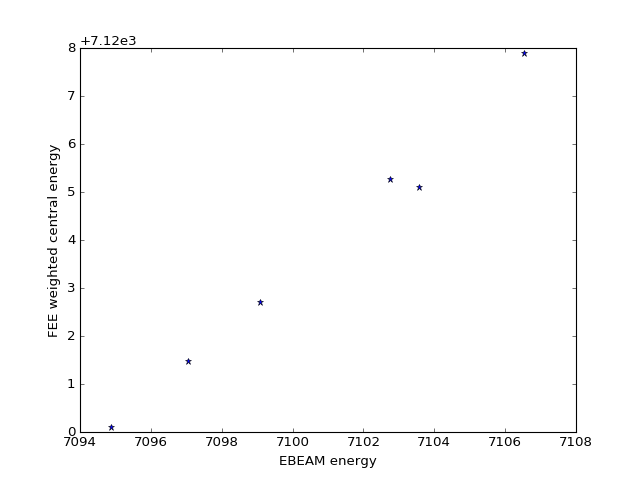

('correlation coefficient', array([[ 1.       ,  0.9945854],
       [ 0.9945854,  1.       ]]))


In [122]:
# Plot correlation between ebeam data and the eV data. Should be positively correlated

ebeam_energy=[]
fee_energy=[]

ds = DataSource('exp=mfxls4916:run=199:smd')
env = ds.env()
fee_spec = AreaDetector('FEE_Spec', env)
figure()
ev_axis=[x*slope+intercept for x in range(2038)]
for nevent,evt in enumerate(ds.events()):
    calib_array = fee_spec.calib(evt)
    e=ebeam.get(evt) 
    if calib_array is not None and e is not None:
        data=calib_array[:,:-10].sum(axis=0) - calib_array[25:50, :-10].sum(axis=0)
        #figure()
        #imshow(calib_array[:,:-10])
        scale_factor = gaus(range(2038),*beam_profile_corr_params)
        scaled_data=(data-min(data))/(scale_factor)
        ebeam_energy.append(e.ebeamPhotonEnergy())
        fee_energy.append(get_center_of_ev_spec(scaled_data))
        if nevent > 20: break
plot(ebeam_energy,fee_energy,'*')
print ('correlation coefficient', np.corrcoef(ebeam_energy, fee_energy))
xlabel('EBEAM energy')
ylabel('FEE weighted central energy')